## Prepare requisites

Rename files to be away from errors

In [ ]:
!cd /content/drive/MyDrive/Torrent/MNIST/;mv t10k-images-idx3-ubyte.idx3-ubyte	t10k-images-idx3-ubyte; mv train-images-idx3-ubyte.idx3-ubyte train-images-idx3-ubyte; mv 	t10k-labels-idx1-ubyte.idx1-ubyte t10k-labels-idx1-ubyte; mv train-labels-idx1-ubyte.idx1-ubyte train-labels-idx1-ubyte

Install dependencies

In [ ]:
!pip install python-mnist skorch

     |████████████████████████████████| 128 kB 11.0 MB/s 


Load data

In [ ]:
import torch
import mnist
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from skorch import NeuralNetClassifier

In [ ]:
data = mnist.MNIST("/content/drive/MyDrive/Torrent/MNIST/")
data.load_training()
X_train = np.array(data.train_images,dtype=np.float32)
y_train = np.array(data.train_labels,dtype=np.int64)
X_train.resize(X_train.shape[0],1,28,28)
X_train/=255.0

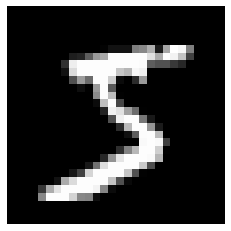

In [ ]:
plt.imshow(X_train[0,0,...],cmap="gray")
plt.axis("off");
#plt.savefig('a1.jpg', bbox_inches='tight')

## Build and train model

In [ ]:
class MyModel(nn.Module):
  def __init__(self,dropout=0.5):
    super(MyModel,self).__init__()
    self.conv1 = nn.Conv2d(1,32,kernel_size=3)
    self.conv2 = nn.Conv2d(32,64,kernel_size=3)
    self.conv2_drop = nn.Dropout(p=dropout)

    self.fc1 = nn.Linear(1600,100)
    self.fc2 = nn.Linear(100,10)
    self.fc1_drop = nn.Dropout(p=dropout)

  
  def forward(self,x):
    x = F.relu(F.max_pool2d(self.conv1(x),2))
    x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)),2))
    x = x.view(-1,x.size(1)*x.size(2)*x.size(3))
    x = F.relu(self.fc1_drop(self.fc1(x)))
    x = F.softmax(self.fc2(x),dim=-1)

    return x

In [ ]:
cnv = nn.Conv2d(32,64,kernel_size=3)
cnv.weight.shape
#a = torch.ones(1,1,28,28)
#print(cnv.weight[0,0,...])
#print(sum(cnv.weight[0,0,...].ravel())+cnv.bias[0])
#print(cnv(a)[0,0,...])

torch.Size([64, 32, 3, 3])

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
torch.manual_seed(0)

model = NeuralNetClassifier(MyModel,max_epochs=60,lr=0.02,optimizer=torch.optim.Adamax,device=device)

Start training

In [ ]:
model.fit(X_train,y_train);

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8867       0.9546        0.1845  1.9110
      2        0.2733       0.9674        0.1255  1.8192
      3        0.2112       0.9757        0.1016  1.8558
      4        0.1845       0.9772        0.0924  1.8217
      5        0.1702       0.9753        0.0915  1.8176
      6        0.1562       0.9800        0.0741  1.8300
      7        0.1386       0.9791        0.0719  1.8226
      8        0.1323       0.9835        0.0608  1.8309
      9        0.1248       0.9822        0.0641  1.8207
     10        0.1159       0.9832        0.0587  1.8311
     11        0.1152       0.9840        0.0572  1.8199
     12        0.1086       0.9832        0.0617  1.8335
     13        0.1045       0.9860        0.0542  1.8309
     14        0.1003       0.9835        0.0570  1.8299
     15        0.0994       0.9866        0.0524  1.8242
     16        0.0960       0.9

## Evaluate trained model

Load test fold

In [ ]:
data.load_testing()
X_test = np.array(data.test_images,dtype=np.float32)
y_test = np.array(data.test_labels,dtype=np.int64)

X_test.resize(X_test.shape[0],1,28,28)
X_test /= 255.0

Test accuracy

In [ ]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(X_test)
accuracy_score(y_test,y_pred)

0.99

In [ ]:
mask = y_test != y_pred
img_incor = X_test[mask,0,...]
pred = y_pred[mask]
test = y_test[mask]

print(f"Inaccurate results: {len(test)}/{len(y_test)}")

Inaccurate results: 100/10000


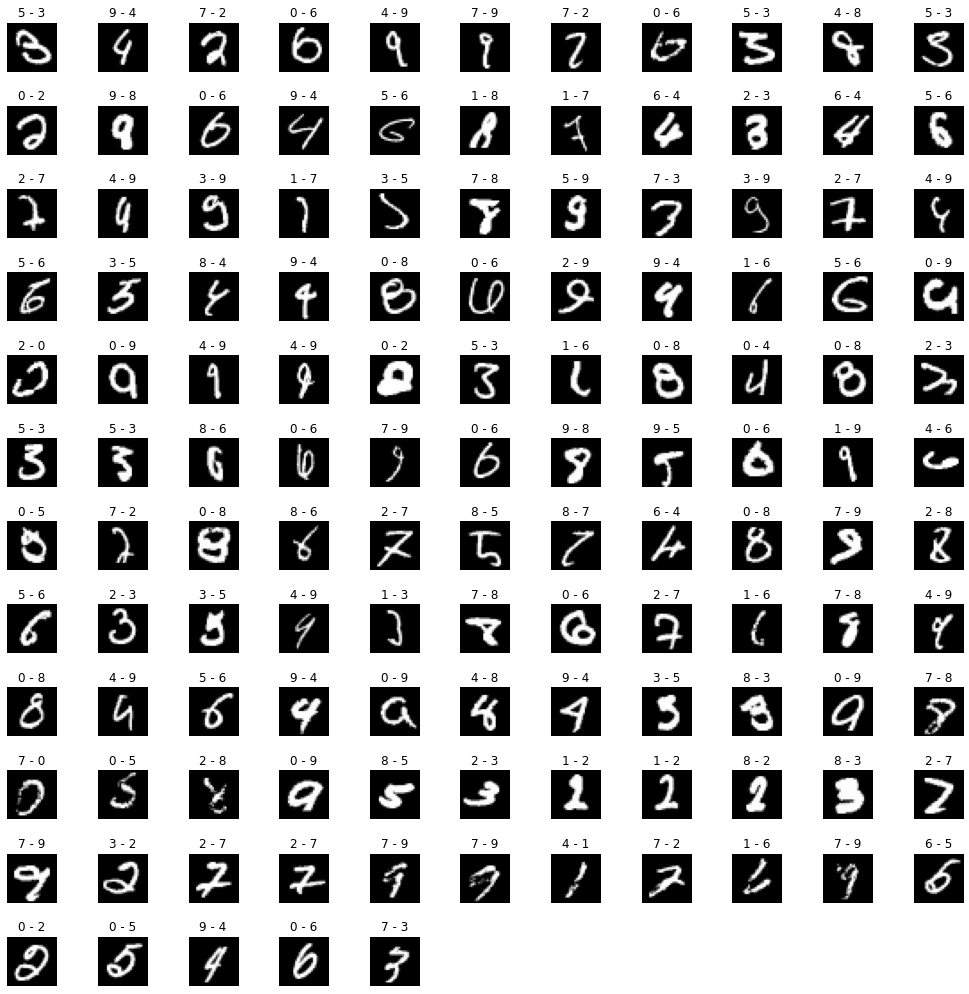

In [ ]:
#shuffle = np.random.choice(img_incor.shape[0],img_incor.shape[0],False)
#img_incor = img_incor[shuffle]
#pred = pred[shuffle]
#test = test[shuffle]

cr = int(np.floor(np.sqrt(len(test))))
fig,axes = plt.subplots(int(np.ceil(len(test)/cr)),cr,figsize=(14,14))
fig.tight_layout()

for i,ax in enumerate(axes.flat):
  ax.axis(False)
  if i >= len(test): continue
  ax.imshow(img_incor[i],cmap="gray")
  ax.set_title(f"{pred[i]} - {test[i]}")


Saving test.png to test.png
prediction: 7


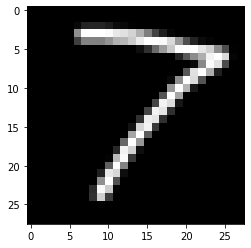

In [ ]:
from google.colab import files
from PIL import Image
from io import BytesIO
import PIL.ImageOps


root = "/content/drive/MyDrive/Torrent/" 
images = files.upload()

for k in images.keys():
    Image.open(BytesIO(images[k])).save(root + k)
    x = Image.open(root + k)
    y = x.resize((28,28))
    y =  PIL.ImageOps.invert(y).convert("L")
    plt.imshow(y,cmap="gray")
    y = np.array(y).reshape(1,1,28,28).astype(np.float32)
    y/=255
    print(f"prediction: {model.predict(y)[0]}")
    


In [ ]:
model.save_params(f_params="model-adamax.pkl")